In [1]:
import tensorflow as tf

from collections import deque

import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import random

C:\Users\conge\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# maze is a 2d Numpy array of floats between 0.0 to 1.0
# 1.0 corresponds to a free cell, and 0.0 an occupied cell
# rat = (row, col) initial rat position (defaults to (0,0))

class Qmaze(object):
    def __init__(self, maze, rat=(0,0)):
        self._maze = np.array(maze)
        nrows, ncols = self._maze.shape
        self.target = (nrows-1, ncols-1)   # target cell where the "cheese" is
        self.free_cells = [(r,c) for r in range(nrows) for c in range(ncols) if self._maze[r,c] == 1.0]
        self.free_cells.remove(self.target)
        if self._maze[self.target] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")
        if not rat in self.free_cells:
            raise Exception("Invalid Rat Location: must sit on a free cell")
        self.reset(rat)

    def reset(self, rat):
        self.rat = rat
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = rat
        self.maze[row, col] = rat_mark
        self.state = (row, col, 'start')
        self.min_reward = -0.5 * self.maze.size
        self.total_reward = 0
        self.visited = set()

    def update_state(self, action):
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = rat_row, rat_col, mode = self.state

        if self.maze[rat_row, rat_col] > 0.0:
            self.visited.add((rat_row, rat_col))  # mark visited cell

        valid_actions = self.valid_actions()
                
        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1
        else:                  # invalid action, no change in rat position
            mode = 'invalid'

        # new state
        self.state = (nrow, ncol, nmode)

    def get_reward(self):
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 1
        return 0

    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status

    def observe(self):
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the rat
        row, col, valid = self.state
        canvas[row, col] = rat_mark
        return canvas

    def game_status(self):
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 'win'

        return 'not_over'

    def valid_actions(self, cell=None):
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape
        if row == 0:
            actions.remove(1)
        elif row == nrows-1:
            actions.remove(3)

        if col == 0:
            actions.remove(0)
        elif col == ncols-1:
            actions.remove(2)

        if row>0 and self.maze[row-1,col] == 0.0:
            actions.remove(1)
        if row<nrows-1 and self.maze[row+1,col] == 0.0:
            actions.remove(3)

        if col>0 and self.maze[row,col-1] == 0.0:
            actions.remove(0)
        if col<ncols-1 and self.maze[row,col+1] == 0.0:
            actions.remove(2)

        return actions

In [3]:
# define neural net Q_\theta(s,a) as a class

class Qfunction(object):
    
    def __init__(self, obssize, actsize, sess, optimizer):
        """
        obssize: dimension of state space
        actsize: dimension of action space
        sess: sess to execute this Qfunction
        optimizer: 
        """
        # YOUR CODE HERE
        # build the prediction graph
        state = tf.placeholder(tf.float32, [None, obssize])
        
        #Construct a FNN with 1 hidden layer
        Layer1_nodes = 24
        W1 = tf.get_variable('W1',[obssize, Layer1_nodes],initializer = tf.truncated_normal_initializer(stddev=.1))
        b1 = tf.get_variable('b1',[Layer1_nodes],initializer = tf.truncated_normal_initializer(stddev=.1))
        h1 = tf.nn.relu(tf.matmul(state,W1) + b1)
        
#         Layer2_nodes = 24
#         W2 = tf.get_variable('W2',[Layer1_nodes, Layer2_nodes],initializer = tf.truncated_normal_initializer(stddev=.1))
#         b2 = tf.get_variable('b2',[Layer2_nodes],initializer = tf.truncated_normal_initializer(stddev=.1))
#         h2 = tf.nn.relu(tf.matmul(h1, W2) + b2)
        
        W2 = tf.get_variable('W2',[Layer1_nodes, actsize],initializer = tf.truncated_normal_initializer(stddev=.1))
        b2 = tf.get_variable('b2',[actsize],initializer = tf.truncated_normal_initializer(stddev=.1))
        h2 = tf.matmul(h1, W2) + b2        
        
        Qvalues = h2  # make sure it has size [None, actsize]
        
        # build the targets and actions
        # targets represent the terms E[r+gamma Q] in Bellman equations
        # actions represent a_t
        targets = tf.placeholder(tf.float32, [None])
        actions = tf.placeholder(tf.int32, [None])
        actions_one_hot = tf.one_hot(actions, actsize)
        Qpreds = tf.reduce_sum(tf.multiply(h2, actions_one_hot), axis=1) # make sure it has size [None]
        loss = tf.reduce_mean(tf.square(Qpreds - targets))

        # optimization
        self.train_op = optimizer.minimize(loss)
        
        # some bookkeeping
        self.Qvalues = Qvalues
        self.state = state
        self.actions = actions
        self.targets = targets
        self.loss = loss
        self.sess = sess
    
    def compute_Qvalues(self, states):
        """
        """
        return self.sess.run(self.Qvalues, feed_dict={self.state: states})

    def train(self, states, actions, targets):
        """
        states: numpy array as input to compute loss (s)
        actions: numpy array as input to compute loss (a)
        targets: numpy array as input to compute loss (Q targets)
        """
        return self.sess.run([self.loss,self.train_op], feed_dict={self.state:states, self.actions:actions, self.targets:targets})

In [4]:
# Implement replay buffer
class ReplayBuffer(object):
    
    def __init__(self, maxlength):
        """
        maxlength: max number of tuples to store in the buffer
        if there are more tuples than maxlength, pop out the oldest tuples
        """
        self.buffer = deque()
        self.number = 0
        self.maxlength = maxlength
    
    def append(self, experience):
        """
        this function implements appending new experience tuple
        experience: a tuple of the form (s,a,r,s^\prime)
        """
        self.buffer.append(experience)
        self.number += 1
        
    def pop(self):
        """
        pop out the oldest tuples if self.number > self.maxlength
        """
        while self.number > self.maxlength:
            self.buffer.popleft()
            self.number -= 1
    
    def sample(self, batchsize):
        """
        this function samples 'batchsize' experience tuples
        batchsize: size of the minibatch to be sampled
        return: a list of tuples of form (s,a,r,s^\prime)
        """
        # YOUR CODE HERE
        if batchsize < self.number:
            minibatch = random.sample(self.buffer, batchsize) 
        else:
            minibatch = random.sample(self.buffer, self.number) 
        return minibatch  # need implementation

In [5]:
def build_target_update(from_scope, to_scope):
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=from_scope)
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=to_scope)
    op = []
    for v1, v2 in zip(from_vars, to_vars):
        op.append(v2.assign(0.2*v1+0.8*v2))
    return op    

In [6]:
# maze = np.array([
#     [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
#     [ 1.,  1.,  1.,  0.,  0.,  1.,  0.],
#     [ 0.,  0.,  0.,  1.,  1.,  1.,  0.],
#     [ 1.,  1.,  1.,  1.,  0.,  0.,  1.],
#     [ 1.,  0.,  0.,  0.,  1.,  1.,  1.],
#     [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
#     [ 1.,  1.,  1.,  0.,  1.,  1.,  1.]
# ])
maze = np.array([
     [ 1.,  0.,  1.,  1.,  1.,  0.,  1.],
     [ 1.,  1.,  1.,  1.,  0.,  1.,  1.],
     [ 1.,  1.,  1.,  0.,  1.,  1.,  1.],
     [ 0.,  1.,  1.,  1.,  1.,  1.,  0.],
     [ 1.,  1.,  0.,  0.,  1.,  1.,  1.],
     [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
     [ 1.,  1.,  1.,  1.,  0.,  1.,  1.]
])
visited_mark = 0.8  # Cells visited by the rat will be painted by gray 0.8
rat_mark = 0.5      # The current rat cell will be painteg by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

rat_cell = (0,0)

In [7]:
def show(qmaze, file_name = 'Maze'):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    rat_row, rat_col, _ = qmaze.state
    canvas[rat_row, rat_col] = 0.3   # rat cell
    canvas[nrows-1, ncols-1] = 0.9 # cheese cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    plt.imshow(canvas, interpolation='none', cmap='gray')
    plt.savefig(file_name)
    return img

C:\Users\conge\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


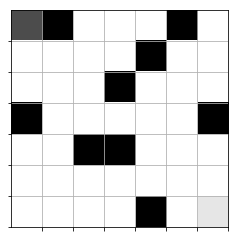

In [8]:
env = Qmaze(maze)
show(env)

Finished 1 episode.rewardsum=1.
Evaluation reward=0.


C:\Users\conge\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\Users\conge\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\conge\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Finished 2 episode.rewardsum=0.
Finished 3 episode.rewardsum=0.
Finished 4 episode.rewardsum=0.
Finished 5 episode.rewardsum=0.
Finished 6 episode.rewardsum=0.
Evaluation reward=0.
Finished 7 episode.rewardsum=0.
Finished 8 episode.rewardsum=0.
Finished 9 episode.rewardsum=1.
Finished 10 episode.rewardsum=0.
Finished 11 episode.rewardsum=1.
Evaluation reward=0.
Finished 12 episode.rewardsum=0.
Finished 13 episode.rewardsum=0.
Finished 14 episode.rewardsum=0.
Finished 15 episode.rewardsum=0.
Finished 16 episode.rewardsum=1.
Evaluation reward=0.
Finished 17 episode.rewardsum=0.
Finished 18 episode.rewardsum=1.
Finished 19 episode.rewardsum=1.
Finished 20 episode.rewardsum=0.
Finished 21 episode.rewardsum=0.
Evaluation reward=0.
Finished 22 episode.rewardsum=1.
Finished 23 episode.rewardsum=0.
Finished 24 episode.rewardsum=0.
Finished 25 episode.rewardsum=0.
Finished 26 episode.rewardsum=0.
Evaluation reward=0.
Finished 27 episode.rewardsum=0.
Finished 28 episode.rewardsum=0.
Finished 29 

Finished 220 episode.rewardsum=1.
Finished 221 episode.rewardsum=0.
Evaluation reward=0.
Finished 222 episode.rewardsum=1.
Finished 223 episode.rewardsum=1.
Finished 224 episode.rewardsum=1.
Finished 225 episode.rewardsum=0.
Finished 226 episode.rewardsum=0.
Evaluation reward=0.
Finished 227 episode.rewardsum=1.
Finished 228 episode.rewardsum=1.
Finished 229 episode.rewardsum=1.
Finished 230 episode.rewardsum=1.
Finished 231 episode.rewardsum=0.
Evaluation reward=0.
Finished 232 episode.rewardsum=1.
Finished 233 episode.rewardsum=1.
Finished 234 episode.rewardsum=0.
Finished 235 episode.rewardsum=1.
Finished 236 episode.rewardsum=1.
Evaluation reward=0.
Finished 237 episode.rewardsum=1.
Finished 238 episode.rewardsum=1.
Finished 239 episode.rewardsum=1.
Finished 240 episode.rewardsum=0.
Finished 241 episode.rewardsum=1.
Evaluation reward=0.
Finished 242 episode.rewardsum=1.
Finished 243 episode.rewardsum=1.
Finished 244 episode.rewardsum=1.
Finished 245 episode.rewardsum=1.
Finished 24

Finished 435 episode.rewardsum=1.
Finished 436 episode.rewardsum=1.
Evaluation reward=0.
Finished 437 episode.rewardsum=1.
Finished 438 episode.rewardsum=1.
Finished 439 episode.rewardsum=1.
Finished 440 episode.rewardsum=1.
Finished 441 episode.rewardsum=1.
Evaluation reward=0.
Finished 442 episode.rewardsum=1.
Finished 443 episode.rewardsum=1.
Finished 444 episode.rewardsum=1.
Finished 445 episode.rewardsum=1.
Finished 446 episode.rewardsum=1.
Evaluation reward=0.
Finished 447 episode.rewardsum=1.
Finished 448 episode.rewardsum=1.
Finished 449 episode.rewardsum=1.
Finished 450 episode.rewardsum=1.
Finished 451 episode.rewardsum=1.
Evaluation reward=0.
Finished 452 episode.rewardsum=1.
Finished 453 episode.rewardsum=1.
Finished 454 episode.rewardsum=1.
Finished 455 episode.rewardsum=1.
Finished 456 episode.rewardsum=1.
Evaluation reward=1.
Finished 457 episode.rewardsum=1.
Finished 458 episode.rewardsum=1.
Finished 459 episode.rewardsum=1.
Finished 460 episode.rewardsum=1.
Finished 46

Finished 650 episode.rewardsum=1.
Finished 651 episode.rewardsum=1.
Evaluation reward=0.
Finished 652 episode.rewardsum=1.
Finished 653 episode.rewardsum=1.
Finished 654 episode.rewardsum=1.
Finished 655 episode.rewardsum=1.
Finished 656 episode.rewardsum=1.
Evaluation reward=1.
Finished 657 episode.rewardsum=1.
Finished 658 episode.rewardsum=1.
Finished 659 episode.rewardsum=1.
Finished 660 episode.rewardsum=1.
Finished 661 episode.rewardsum=1.
Evaluation reward=0.
Finished 662 episode.rewardsum=1.
Finished 663 episode.rewardsum=1.
Finished 664 episode.rewardsum=1.
Finished 665 episode.rewardsum=1.
Finished 666 episode.rewardsum=1.
Evaluation reward=0.
Finished 667 episode.rewardsum=1.
Finished 668 episode.rewardsum=1.
Finished 669 episode.rewardsum=1.
Finished 670 episode.rewardsum=1.
Finished 671 episode.rewardsum=1.
Evaluation reward=0.
Finished 672 episode.rewardsum=1.
Finished 673 episode.rewardsum=1.
Finished 674 episode.rewardsum=1.
Finished 675 episode.rewardsum=1.
Finished 67

Finished 865 episode.rewardsum=1.
Finished 866 episode.rewardsum=1.
Evaluation reward=0.
Finished 867 episode.rewardsum=1.
Finished 868 episode.rewardsum=1.
Finished 869 episode.rewardsum=1.
Finished 870 episode.rewardsum=1.
Finished 871 episode.rewardsum=1.
Evaluation reward=1.
Finished 872 episode.rewardsum=1.
Finished 873 episode.rewardsum=1.
Finished 874 episode.rewardsum=1.
Finished 875 episode.rewardsum=1.
Finished 876 episode.rewardsum=1.
Evaluation reward=1.
Finished 877 episode.rewardsum=1.
Finished 878 episode.rewardsum=1.
Finished 879 episode.rewardsum=1.
Finished 880 episode.rewardsum=1.
Finished 881 episode.rewardsum=1.
Evaluation reward=0.
Finished 882 episode.rewardsum=1.
Finished 883 episode.rewardsum=1.
Finished 884 episode.rewardsum=1.
Finished 885 episode.rewardsum=1.
Finished 886 episode.rewardsum=1.
Evaluation reward=1.
Finished 887 episode.rewardsum=1.
Finished 888 episode.rewardsum=1.
Finished 889 episode.rewardsum=1.
Finished 890 episode.rewardsum=1.
Finished 89

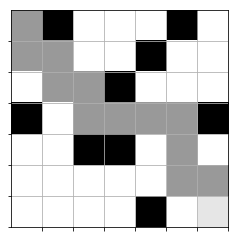

In [9]:
# parameter initializations
lr = 1e-3  # learning rate for gradient update
batchsize = 64  # batchsize for buffer sampling
maxlength = 10000  # max number of tuples held by buffer

tau = 100  # time steps for target update
episodes = 1000 # number of episodes to run
initialsize = 500  # initial time steps before start updating
epsilon_min = 0.01 # constant for exploration
epsilon_decay = 0.999
gamma = .99  # discount
maxsteps = 100

reward_record = []
evaluation_record = []

# initialize environment
env = Qmaze(maze)
obssize = 49
actsize = num_actions

# initialize tensorflow session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# optimizer
optimizer = tf.train.AdamOptimizer(lr)

# initialize networks
with tf.variable_scope("principal"):
    Qprincipal = Qfunction(obssize, actsize, sess, optimizer)
with tf.variable_scope("target"):
    Qtarget = Qfunction(obssize, actsize, sess, optimizer)

# build ops
update = build_target_update("principal", "target")  # call sess.run(update) to copy
                                                     # from principal to target

# initialization of graph and buffer
sess.run(tf.global_variables_initializer())
buffer = ReplayBuffer(maxlength)
sess.run(update)

# main iteration
# YOUR CODE HERE
counter = 0
epsilon =1.0
for e in range(episodes):
    env.reset(rat_cell)
    done = 'not_over'
    rewardsum = 0
    epsilon = max(0.1,epsilon * 0.995)
    
    obs = env.observe()
    
    for _ in range(maxsteps):
        valid_actions = env.valid_actions()
        if not valid_actions: break
        counter = counter + 1
        
        if np.random.rand() < epsilon:
            action = random.choice(valid_actions)
        else:
            values = Qprincipal.compute_Qvalues(obs)
            action = np.argmax(values)


        obs_, reward, done = env.act(action)
        
        rewardsum += reward
        
        #Implement buffer replay to store memory
        experience = (obs, action, reward, obs_)
        buffer.append(experience)
        buffer.pop()
        
            
        if counter>initialsize and counter%5 == 0:
            #Sample from stored memory
            Samples = buffer.sample(batchsize)

            #Conpute target_i
            states = []
            actions = []
            targets = []
            for i in range(len(Samples)):
                s_current, action, r, s_next = Samples[i]
                Q_target = Qtarget.compute_Qvalues(s_next)
                states.extend(s_current)
                actions.append(action)
                target = r + gamma * np.max(Q_target)
                targets.append(target)

            #Compute empirical loss, update theta
            Qprincipal.train(states, actions, targets)
            
        #Update target network
        if counter % tau == 0:
            sess.run(update)
        if done == 'win':
            break
            
        #Swap observation
        obs = obs_
    reward_record.append(rewardsum)
    
   
    print('Finished {} episode.rewardsum={}.'.format(e+1,rewardsum))
    show(env, file_name = 'maze/Maze'+'test_1_'+str(e+1))
    
    ## Define a evaluation episode
    if e % 5 == 0:
        env.reset(rat_cell)
        done = 'not_over'
        rewardsum = 0
        
        obs = env.observe()
        
        for _ in range(50):
            values = Qprincipal.compute_Qvalues(obs)
            action = np.argmax(values)
            obs_, reward, done = env.act(action)

            rewardsum += reward
            
            if done == 'win':
                break
            obs = obs_
        evaluation_record.append(rewardsum)
        print('Evaluation reward={}.'.format(rewardsum))
        show(env, file_name = 'maze_evaluation/Maze'+'test_1_'+str(e+1))
        with open('DQN_rewardsEval.dat', 'a') as eval_reward_file:
             print(np.mean(evaluation_record[:-10]), file=eval_reward_file)

In [10]:
for i in range(200):
    with open('DQN_rewardsEval_1.dat', 'a') as eval_reward_file:
        if i < 10:
            print(np.mean(evaluation_record[:i]), file=eval_reward_file)
        else:
            print(np.mean(evaluation_record[(i-10):i]), file=eval_reward_file)
    

C:\Users\conge\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\conge\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
